In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from kerasbeats import prep_time_series, NBeatsModel
from keras import optimizers
import sys
import os
module_path = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath('nbeats.ipynb')),'..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from data import preprocess, postprocess
from model import fft, lstm
from evaluate import evaluateModel, evaluateProfit

In [2]:
stock_name = "^GSPC"
date_predict_start = '2015-01-01'
window_length = 250
slide_range = 25
total_windows = 10

pv_range = 7
profit_percentage = 0.08
loss_percentage = 0.08

n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'

x_length = 25
y_length = 25
slide = 25

train_data_num = 50
epochs = 50

In [3]:
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import yfinance as yf


class LoadData:
    """
    Class to load and split stock data.

    Attributes:
        stock_name (str): Name of the stock.
        window_length (int): Length of the window for splitting data.
        slide_range (int): Range of sliding window for splitting data.
        total_windows (int): Total number of windows for splitting data.
        columns_num (int): Number of columns to consider from the stock data.
        columns (list): List of column names to consider from the stock data.
        train_data (numpy.ndarray): Array to store training data. Shape: (total_windows, window_length, columns_num)
        train_data_index (numpy.ndarray): Array to store indices of training data. Shape: (total_windows, window_length)
        test_data (numpy.ndarray): Array to store testing data. Shape: (total_windows, window_length, columns_num)
        test_data_index (numpy.ndarray): Array to store indices of testing data. Shape: (total_windows, window_length)
    """

    def __init__(self, stock_name, window_length, slide_range, total_windows, input_num=1):
        self.stock_name = stock_name
        self.window_length = int(window_length)
        self.slide_range = int(slide_range)
        self.total_windows = int(total_windows)
        self.columns_num = input_num - 1 if input_num != 1 else 1
        self.columns = ['Close', 'Open', 'High', 'Low', 'Volume']
        self.train_data = np.zeros(shape=(total_windows, window_length, self.columns_num), dtype=float)
        self.train_data_index = np.zeros(shape=(total_windows, window_length), dtype=object)
        self.test_data = np.zeros(shape=(total_windows, window_length, self.columns_num), dtype=float)
        self.test_data_index = np.zeros(shape=(total_windows, window_length), dtype=object)

        self.date_data_start_list = []
        self.date_predict_start_list = []
        self.date_predict_end_list = []
        self.test_data_start_list = []

    def load_and_split_data(self, date_predict_start):
        """
        Load and split data into training and testing sets.

        Args:
            date_predict_start (str): Start date for prediction.

        Returns:
            Tuple containing training data, testing data, training data indices, testing data indices, and all data.
        """
        all_data = yf.Ticker(self.stock_name).history(period='max').drop(columns=['Dividends', 'Stock Splits'])
        all_data.index = all_data.index.date
        date_predict_start = self._check_start(date_predict_start, all_data)
        predict_start = all_data.index.get_loc(date_predict_start)
        for i in range(self.total_windows):
            predict_end = predict_start + self.window_length
            data_start = predict_start - self.window_length
            self.train_data[i, :] = all_data[self.columns[:self.columns_num]].iloc[data_start:predict_start].values
            self.train_data_index[i, :] = all_data.iloc[data_start:predict_start].index
            self.test_data[i, :] = all_data[self.columns[:self.columns_num]].iloc[predict_start:predict_end].values
            self.test_data_index[i, :] = all_data.iloc[predict_start:predict_end].index
            predict_start = predict_start + self.slide_range
        return self.train_data, self.test_data, self.train_data_index, self.test_data_index, all_data

    def _check_start(self, date_predict_start, all_data):
        """
        Check if the prediction start date is valid.

        Args:
            date_predict_start (str): Start date for prediction.
            all_data (pd.DataFrame): All stock data.

        Returns:
            Valid start date for prediction.
        """
        date_predict_start = pd.to_datetime(date_predict_start)
        valid_date = all_data.index.asof(date_predict_start)
        return valid_date


In [4]:
dataloader = LoadData(stock_name, window_length, slide_range, total_windows, 6)
train_data, test_data, train_data_index, test_data_index, all_data =\
    dataloader.load_and_split_data(date_predict_start)


C:\Users\e4903\AppData\Local\Temp\ipykernel_6200\2969846758.py:79: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  valid_date = all_data.index.asof(date_predict_start)


In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


class Preprocess:
    """
    Class to preprocess training and testing data.

    Attributes:
        x_length (int): Length of the input sequence.
        y_length (int): Length of the target sequence.
    """

    def __init__(self, x_length, y_length):
        self.x_length = x_length
        self.y_length = y_length

    def preprocess_train_data(self, train_data):
        """
        Preprocess training data.

        Args:
            train_data (numpy.ndarray): Training data. Shape: (number of windows, window length, number of features)
            self.x_length (int): Length of the input sequence.
            self.y_length (int): Length of the target sequence.

        Returns:
            Tuple containing preprocessed input data, target data, and scaler object.
        """
        split_num = len(range(self.x_length + self.y_length, train_data.shape[1]))
        train_x = np.zeros((train_data.shape[0], split_num, self.x_length, train_data.shape[-1]))
        train_y = np.zeros((train_data.shape[0], split_num, self.y_length))
        scaler = MinMaxScaler(feature_range=(0, 1))
        for window in range(train_data.shape[0]):
            for columns in range(train_data.shape[-1]):
                scaled_data_train = scaler.fit_transform(train_data[window, :, columns].reshape(-1, 1)).flatten()
                split_count = 0
                for i in range(self.x_length + self.y_length, len(scaled_data_train)):
                    train_x[window, split_count, :, columns] = scaled_data_train[i - self.x_length - self.y_length:i - self.y_length]
                    if columns == 0:
                        train_y[window, split_count] = scaled_data_train[i - self.y_length:i]
                    split_count += 1
        return train_x, train_y, scaler

    def preprocess_test_data(self, train_data, test_data, slide=1):
        """
        Preprocess testing data.

        Args:
            train_data (numpy.ndarray): Data used for scaling. Shape: (number of windows, window length, number of features)
            test_data (numpy.ndarray): Testing data. Shape: (number of windows, window length, number of features)
            self.x_length (int): Length of the input sequence.
            self.y_length (int): Length of the target sequence.
            slide (int): Sliding window step size. Default is 1.

        Returns:
            Tuple containing preprocessed input data, target data, and scaler object.
        """
        split_num = len(range(self.x_length + self.y_length, test_data.shape[1], slide)) + 1
        test_x = np.zeros((test_data.shape[0], split_num, self.x_length, test_data.shape[-1]))
        test_y = np.zeros((test_data.shape[0], split_num, self.y_length))
        scaler = MinMaxScaler(feature_range=(0, 1))
        for window in range(test_data.shape[0]):
            for columns in range(test_data.shape[-1]):
                scaled_data_train = scaler.fit_transform(train_data[window, :, columns].reshape(-1, 1)).flatten()
                scaled_data_test = scaler.fit_transform(test_data[window, :, columns].reshape(-1, 1)).flatten()
                split_count = 0
                test_x[window, split_count, :, columns] = scaled_data_train[-self.x_length:]
                if columns == 0:
                    test_y[window, split_count] = scaled_data_test[:self.y_length]
                split_count += 1
                for i in range(self.x_length + self.y_length, len(scaled_data_test), slide):
                    test_x[window, split_count, :, columns] = scaled_data_test[i - self.x_length - self.y_length:i - self.y_length]
                    if columns == 0:
                        test_y[window, split_count] = scaled_data_test[i - self.y_length:i]
                    split_count += 1
        return test_x, test_y, scaler


In [6]:
# extra_train_data, extra_train_data_index = dataloader.load_extra_train_data(date_predict_start, train_data_num, x_length)
all_data_index = all_data.index
preprocesser = Preprocess(x_length, y_length)
x_train, y_train, scaler =\
    preprocesser.preprocess_train_data(train_data)
x_test, y_test, scaler =\
    preprocesser.preprocess_test_data(train_data, test_data, slide=slide)

In [9]:
class Nbeats:
    def __init__(self):
        pass
    
    def nbeats(self, x_train, y_train, x_test, y_test, train_data, test_data, y_length, epochs):
        """
        Trains and predicts using LSTM model.

        Args:
            x_train (array): Training input data.
            y_train (array): Training target data.
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            train_data (array): Training data.
            y_length (int): Length of the target data.

        Returns:
            array: Processed signal obtained from predictions.
        """
        model = self._build(x_train, y_length)
        history = self._train(train_data, model, x_train, y_train, epochs)
        predicted_y = self._predict(x_test, y_test, test_data, model)
        # processed_signal = self._flatten(predicted_y)
        return predicted_y, history

    def _construct(self, y_length):
        """
        Constructs an LSTM model.

        Args:
            y_length (int): Length of the target data.
            input_shape (tuple): Shape of the input data.

        Returns:
            Sequential: Constructed LSTM model.
        """
        model = NBeatsModel(model_type = 'generic', lookback = 1, horizon = y_length)
        return model
    
    def _build(self, x_train, y_length):
        """
        Builds a list of LSTM models.

        Args:
            x_train (array): Training input data.
            y_length (int): Length of the target data.

        Returns:
            list: List of built LSTM models.
        """
        model = self._construct(y_length)
        # model[i].compile(loss = 'mse',
        #          optimizer = optimizers.RMSprop(0.001))
        # model[i].summary()
        return model
    
    def _train(self, train_data, model, x_train, y_train, epochs):
        """
        Trains the LSTM models.

        Args:
            train_data (array): Training data.
            model (list): List of LSTM models.
            x_train (array): Training input data.
            y_train (array): Training target data.

        Returns:
            list: List of training histories.
        """
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history = model.fit(x_train, y_train, epochs=epochs)
        return history
    
    def _predict(self, x_test, y_test, test_data, model):
        """
        Generates predictions using the trained models.

        Args:
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            model (list): List of LSTM models.

        Returns:
            predicted_y: numpy.ndarray
                Processed signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)
        """
        predicted_y = np.ndarray([y_test.shape[0], y_test.shape[1], y_test.shape[2]])
        for i in tqdm(range(0, test_data.shape[0])):
            predicted_prices = model.predict(x_test[i])
            predicted_y[i] = predicted_prices
        return predicted_y

In [10]:
class Lstm:
    def __init__(self):
        pass
    
    def lstm(self, x_train, y_train, x_test, y_test, train_data, test_data, y_length, epochs):
        """
        Trains and predicts using LSTM model.

        Args:
            x_train (array): Training input data.
            y_train (array): Training target data.
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            train_data (array): Training data.
            y_length (int): Length of the target data.

        Returns:
            array: Processed signal obtained from predictions.
        """
        model = self._build(x_train, y_length)
        history = self._train(model, x_train, y_train, epochs)
        predicted_y, evaluate = self._predict(x_test, y_test, test_data, model)
        # processed_signal = self._flatten(predicted_y)
        return predicted_y, history, evaluate

    def _construct(self, y_length, input_shape):
        """
        Constructs an LSTM model.

        Args:
            y_length (int): Length of the target data.
            input_shape (tuple): Shape of the input data.

        Returns:
            Sequential: Constructed LSTM model.
        """
        model = Sequential()
        model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
        model.add(Dropout(0.4))
        model.add(LSTM(units = 128, return_sequences = True))
        model.add(Dropout(0.4))
        model.add(LSTM(units = 64))
        model.add(Dropout(0.4))
        model.add(Dense(units=y_length))
        return model
    
    def _build(self, x_train, y_length):
        """
        Builds a list of LSTM models.

        Args:
            x_train (array): Training input data.
            y_length (int): Length of the target data.

        Returns:
            list: List of built LSTM models.
        """
        input_shape = (x_train.shape[-2], x_train.shape[-1])
        print(input_shape)
        model = self._construct(y_length, input_shape)
        model.compile(optimizer='adam', 
                    loss='mean_squared_error')
            # model[i].summary()
        return model
    
    def _train(self, model, x_train, y_train, epochs):
        """
        Trains the LSTM models.

        Args:
            train_data (array): Training data.
            model (list): List of LSTM models.
            x_train (array): Training input data.
            y_train (array): Training target data.

        Returns:
            list: List of training histories.
        """
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
        history = list()
        for window in range(0, x_train.shape[0]):
            history.append(model.fit(x_train[window], y_train[window], epochs=epochs, batch_size=32, 
                                callbacks = [earlystopper], validation_split = 0.2, shuffle=True))
        return history
    
    def _predict(self, x_test, y_test, test_data, model):
        """
        Generates predictions using the trained models.

        Args:
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            model (list): List of LSTM models.

        Returns:
            predicted_y: numpy.ndarray
                Processed signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)
        """
        predicted_y = np.ndarray([y_test.shape[0], y_test.shape[1], y_test.shape[2]])
        evaluate = np.ndarray([y_test.shape[0], 2])
        for i in tqdm(range(0, test_data.shape[0])):
            predicted_prices = model.predict(x_test[i])
            evaluate[i] = model.evaluate(x_test[i], y_test[i])
            predicted_y[i] = predicted_prices
        return predicted_y, evaluate
    

In [16]:
post = postprocess.Postprocess()
pv_x_train = post.find_data_pv(x_train[:,:,:,0].reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2]), pv_range)
pv_x_train = pv_x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = np.concatenate((x_train, pv_x_train), axis=-1)
pv_x_test = post.find_data_pv(x_test[:,:,:,0].reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2]), pv_range)
pv_x_test = pv_x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = np.concatenate((x_test, pv_x_test), axis=-1)

In [18]:
shuffle_index = np.random.permutation(x_train.shape[1])
x_train_shuffled = x_train[:, shuffle_index]
y_train_shuffled = y_train[:, shuffle_index]

In [21]:
model = Lstm()
lstm_processed_signal, history, evaluate = model.lstm(x_train_shuffled, y_train_shuffled, x_test, y_test, train_data, test_data, y_length, epochs)

(25, 6)
Epoch 1/50
5/5 [==============================] - 6s 407ms/step - loss: 0.2465 - val_loss: 0.0499
Epoch 2/50
5/5 [==============================] - 1s 134ms/step - loss: 0.1201 - val_loss: 0.0523
Epoch 3/50
5/5 [==============================] - 1s 130ms/step - loss: 0.0932 - val_loss: 0.0390
Epoch 4/50
5/5 [==============================] - 1s 133ms/step - loss: 0.0726 - val_loss: 0.0344
Epoch 5/50
5/5 [==============================] - 1s 129ms/step - loss: 0.0643 - val_loss: 0.0340
Epoch 6/50
5/5 [==============================] - 1s 132ms/step - loss: 0.0590 - val_loss: 0.0272
Epoch 7/50
5/5 [==============================] - 1s 129ms/step - loss: 0.0562 - val_loss: 0.0339
Epoch 8/50
5/5 [==============================] - 1s 127ms/step - loss: 0.0535 - val_loss: 0.0165
Epoch 9/50
5/5 [==============================] - 1s 130ms/step - loss: 0.0511 - val_loss: 0.0277
Epoch 10/50
5/5 [==============================] - 1s 130ms/step - loss: 0.0470 - val_loss: 0.0308
Epoch 11/50

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0076


 10%|█         | 1/10 [00:01<00:09,  1.08s/it]

1/1 [==============================] - 0s 32ms/step - loss: 0.0071


 20%|██        | 2/10 [00:01<00:04,  1.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0265


 30%|███       | 3/10 [00:01<00:02,  2.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0317


 40%|████      | 4/10 [00:01<00:01,  3.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0334


 50%|█████     | 5/10 [00:01<00:01,  4.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0492


 60%|██████    | 6/10 [00:01<00:00,  5.72it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0537


 70%|███████   | 7/10 [00:01<00:00,  6.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0566


 80%|████████  | 8/10 [00:01<00:00,  6.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0589


 90%|█████████ | 9/10 [00:02<00:00,  6.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0577


100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


In [22]:
import matplotlib.pyplot as plt

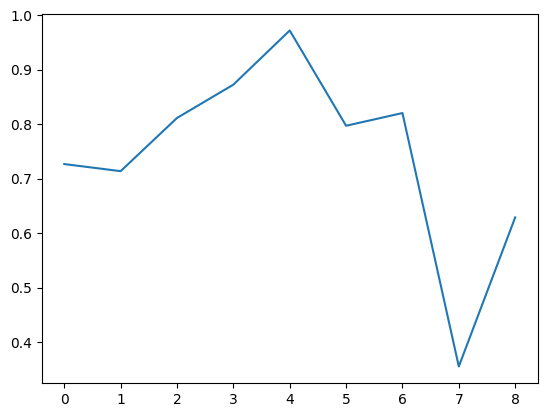

In [23]:
plt.plot(y_test[0,:,0].flatten())

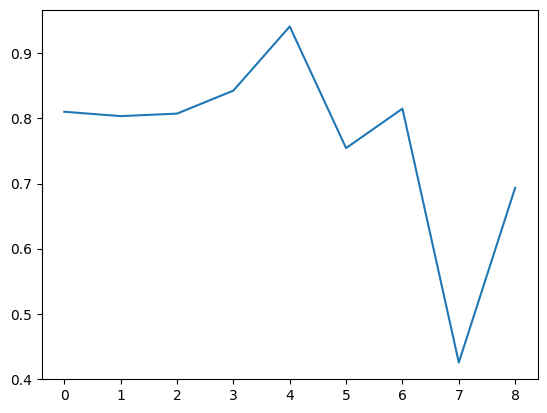

In [24]:
plt.plot(lstm_processed_signal[0,:,0].flatten())

In [25]:
# # initialize N-Beats and fit
# nbeats = NBeatsModel(model_type = 'generic', lookback = x_length, horizon = 1)
# nbeats.fit(x_train[0], y_train[0], epochs = 30)

In [26]:
post = postprocess.Postprocess()
processed_signal = post.postprocess_lstm(lstm_processed_signal, scaler)
pv_train_data = post.find_data_pv(train_data[:,:,0], pv_range)
pv_test_data = post.find_data_pv(test_data[:,:,0], pv_range)
pv_signal = post.find_data_pv(processed_signal, pv_range)
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

In [27]:
# processed_signal, best_fit_harm, best_fit_error = post.postprocess_fft(
#     mixed_train_harm, mixed_test_harm, pv_range, pv_train_data, fit_method)
# pv_signal = post.find_data_pv(processed_signal, pv_range)

In [28]:
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

In [29]:
best_fit_harm = None
best_fit_error = None

In [30]:
evaluater = evaluateModel.Evaluate()
result_table, average_lead = evaluater.evaluate_model(processed_signal, all_data_index, test_data_index, best_fit_harm, best_fit_error, first_date, lead, pv)
print('average_lead = ', average_lead)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(result_table)

average_lead =  3.3


,s_date,t_date,lead,ans_date,pv,best_fit,error
0,2014-12-31,2015-02-04,-3,2015-01-30,valley,NaN,NaN
1,2015-02-06,2015-02-23,5,2015-03-02,peak,NaN,NaN
2,2015-03-16,2015-03-25,-3,2015-03-20,peak,NaN,NaN
3,2015-04-21,2015-04-23,9,2015-05-06,valley,NaN,NaN
4,2015-05-27,2015-06-04,2,2015-06-08,valley,NaN,NaN
5,2015-07-01,2015-07-02,3,2015-07-08,valley,NaN,NaN
6,2015-08-06,2015-08-10,0,2015-08-10,peak,NaN,NaN
7,2015-09-11,2015-09-28,0,2015-09-28,valley,NaN,NaN
8,2015-10-16,2015-11-06,-3,2015-11-03,peak,NaN,NaN
9,2015-11-20,2015-11-23,5,2015-12-01,peak,NaN,NaN


evaluater = evaluateProfit.EvaluateProfit()

In [31]:
evaluater = evaluateProfit.EvaluateProfit()

total_profit = 238.159423828125


,in_date,in_price,out_date,out_price,pv,profit,profitability
0,2015-02-04,2048.86,2015-02-13,2096.99,valley,48.13,0.0235 %
1,2015-02-23,2109.83,2015-03-04,2098.53,peak,11.3,0.0054 %
2,2015-03-25,2093.1,2015-04-06,2080.62,peak,12.48,0.006 %
3,2015-04-23,2107.21,2015-05-04,2114.49,valley,7.28,0.0035 %
4,2015-06-04,2112.35,2015-06-15,2084.43,valley,-27.92,-0.0132 %
5,2015-07-02,2078.03,2015-07-14,2108.95,valley,30.92,0.0149 %
6,2015-08-10,2080.98,2015-08-19,2079.61,peak,1.37,0.0007 %
7,2015-09-28,1929.18,2015-10-07,1995.83,valley,66.65,0.0345 %
8,2015-11-06,2098.6,2015-11-17,2050.44,peak,48.16,0.0229 %
9,2015-11-23,2089.41,2015-12-03,2049.62,peak,39.79,0.019 %


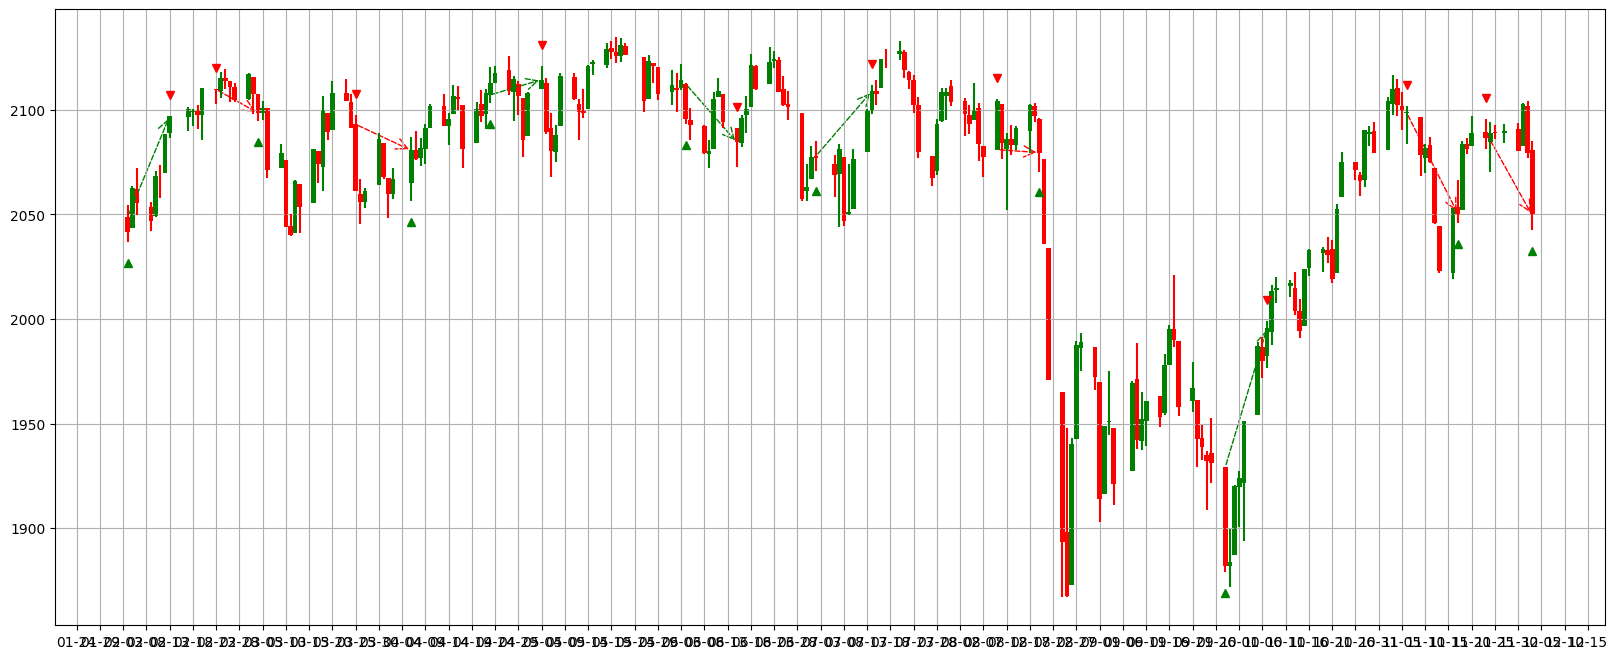

In [32]:
total_profit, profit_table = evaluater.build_profit_table_strategy_1(result_table, all_data, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

total_profit = 238.159423828125


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2015-02-04,2048.86,2015-02-13,2096.99,valley,48.13,NaN,NaN,0.0235 %
1,2015-02-23,2109.83,2015-03-04,2098.53,peak,11.3,NaN,NaN,0.0054 %
2,2015-03-25,2093.1,2015-04-06,2080.62,peak,12.48,NaN,NaN,0.006 %
3,2015-04-23,2107.21,2015-05-04,2114.49,valley,7.28,NaN,NaN,0.0035 %
4,2015-06-04,2112.35,2015-06-15,2084.43,valley,-27.92,NaN,NaN,-0.0132 %
5,2015-07-02,2078.03,2015-07-14,2108.95,valley,30.92,NaN,NaN,0.0149 %
6,2015-08-10,2080.98,2015-08-19,2079.61,peak,1.37,NaN,NaN,0.0007 %
7,2015-09-28,1929.18,2015-10-07,1995.83,valley,66.65,NaN,NaN,0.0345 %
8,2015-11-06,2098.6,2015-11-17,2050.44,peak,48.16,NaN,NaN,0.0229 %
9,2015-11-23,2089.41,2015-12-03,2049.62,peak,39.79,NaN,NaN,0.019 %


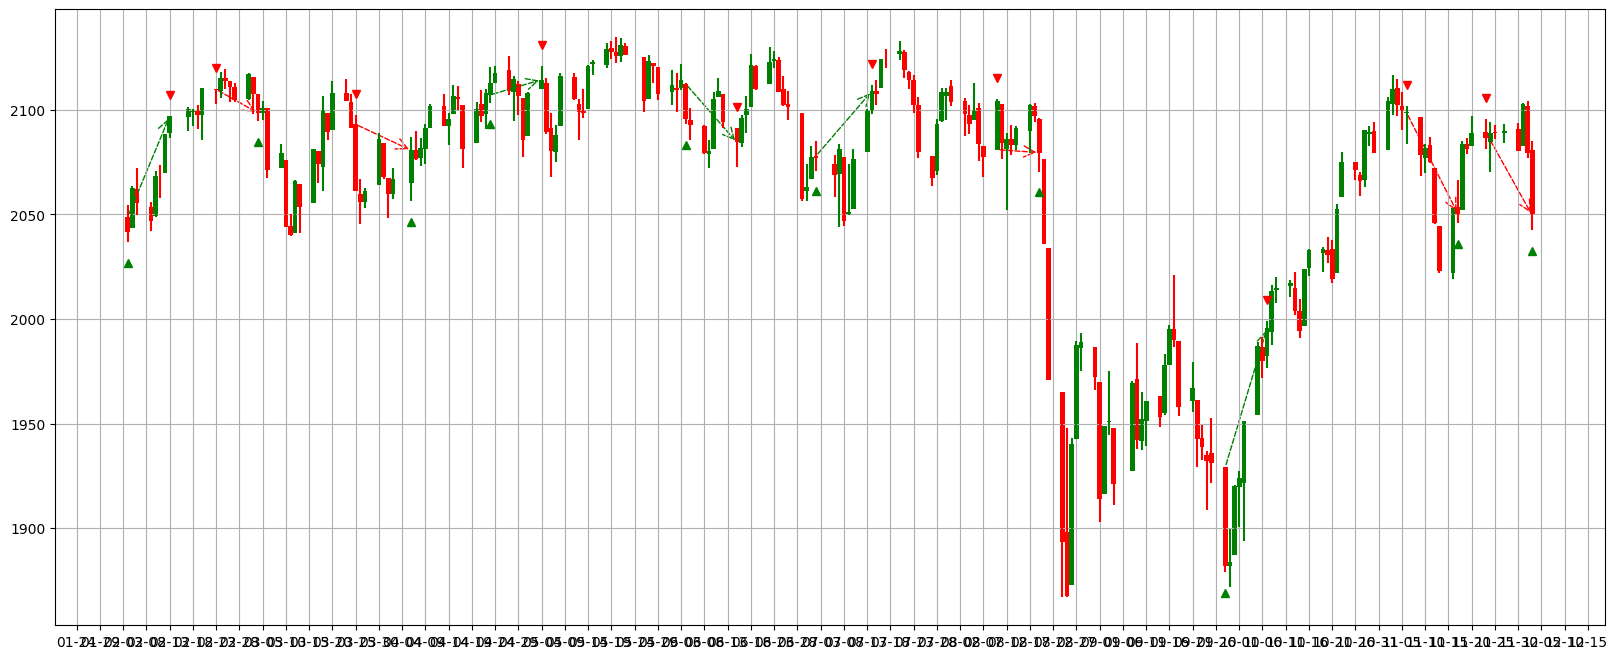

In [33]:
total_profit, profit_table = evaluater.build_profit_table_strategy_2(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

total_profit = 238.159423828125


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2015-02-04,2048.86,2015-02-13,2096.99,valley,48.13,NaN,NaN,0.0235 %
1,2015-02-23,2109.83,2015-03-04,2098.53,peak,11.3,NaN,NaN,0.0054 %
2,2015-03-25,2093.1,2015-04-06,2080.62,peak,12.48,NaN,NaN,0.006 %
3,2015-04-23,2107.21,2015-05-04,2114.49,valley,7.28,NaN,NaN,0.0035 %
4,2015-06-04,2112.35,2015-06-15,2084.43,valley,-27.92,NaN,NaN,-0.0132 %
5,2015-07-02,2078.03,2015-07-14,2108.95,valley,30.92,NaN,NaN,0.0149 %
6,2015-08-10,2080.98,2015-08-19,2079.61,peak,1.37,NaN,NaN,0.0007 %
7,2015-09-28,1929.18,2015-10-07,1995.83,valley,66.65,NaN,NaN,0.0345 %
8,2015-11-06,2098.6,2015-11-17,2050.44,peak,48.16,NaN,NaN,0.0229 %
9,2015-11-23,2089.41,2015-12-03,2049.62,peak,39.79,NaN,NaN,0.019 %


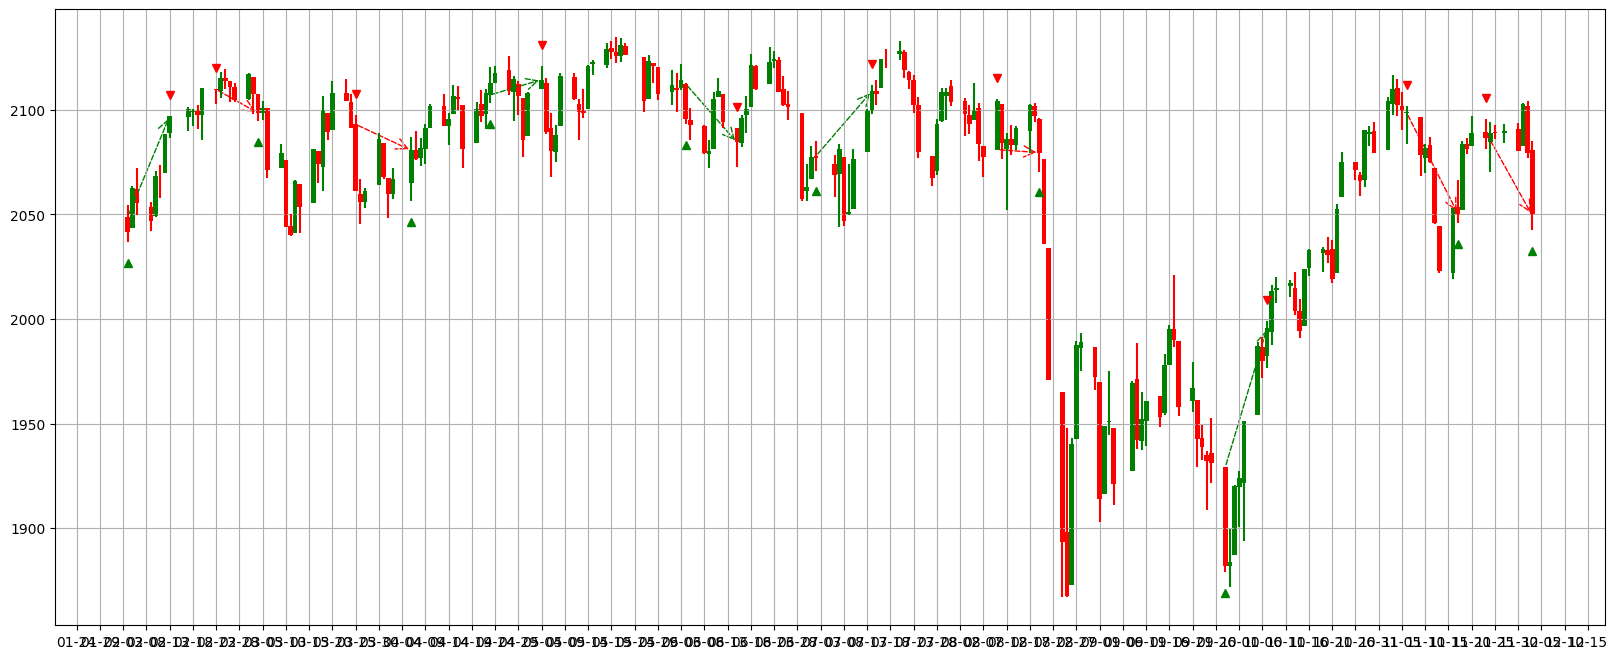

In [34]:
total_profit, profit_table = evaluater.build_profit_table_strategy_3(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

In [35]:
# fig, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
# ax[0].plot(y_test[0].flatten(), label='y_test')
# ax[1].plot(lstm_processed_signal[0].flatten(), label='signal')
# # for x , pv in enumerate(pv_test_data[0]):
# #     if pv == 1:
# #         ax[0].plot(x, y_test[0].flatten()[x], '^', color='orange')
# #     elif pv == -1:
# #         ax[0].plot(x, y_test[0].flatten()[x], 'v', color='red')
# # for x , pv in enumerate(pv_signal[0]):
# #     if pv == 1:
# #         ax[1].plot(x, lstm_processed_signal[0].flatten()[x], '^', color='orange')
# #     elif pv == -1:
# #         ax[1].plot(x, lstm_processed_signal[0].flatten()[x], 'v', color='red')
# ax[0].legend()
# ax[1].legend()
# plt.show()

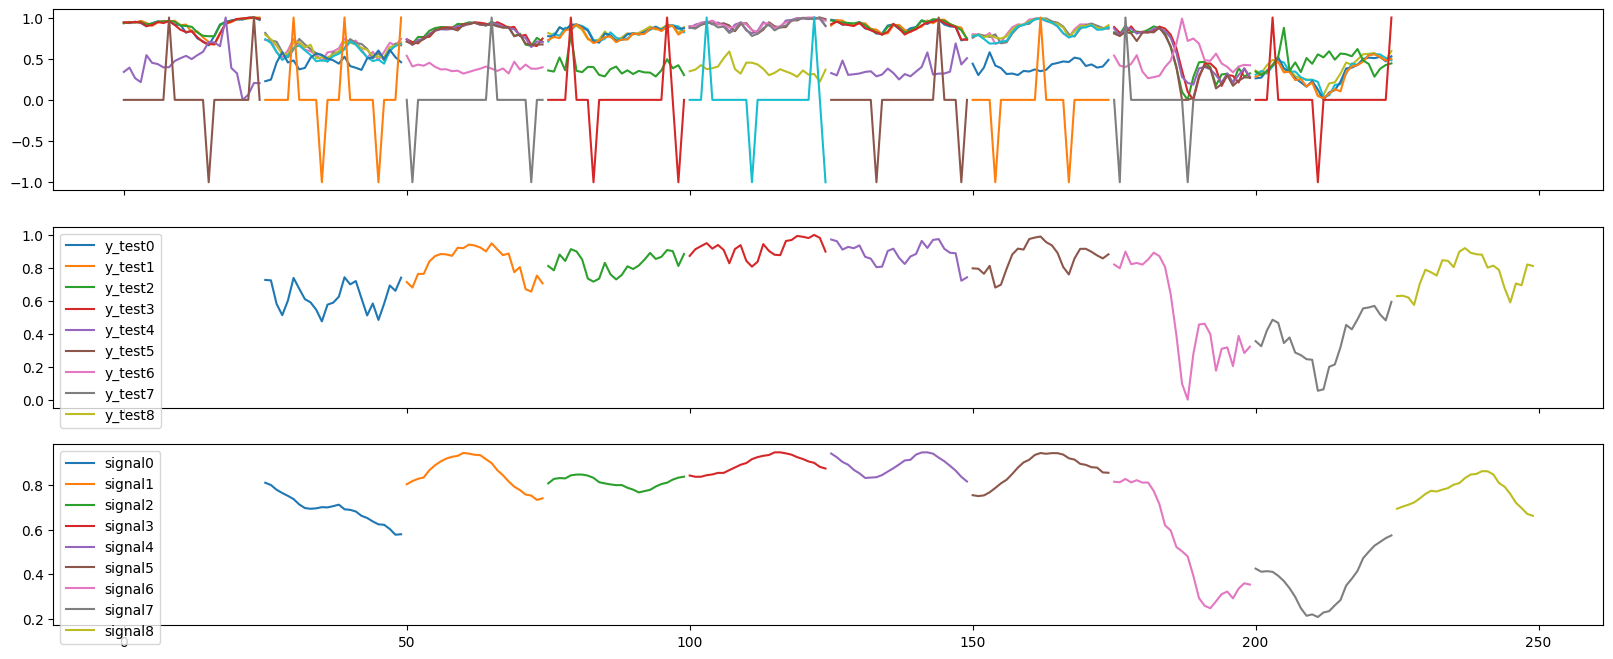

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(20, 8), sharex=True)
count=0
for i in range(0, x_test.shape[1]): 
    # print(i)
    countx=range(count, count+x_length)
    county=range(count+x_length, count+x_length+y_length)
    ax[0].plot(countx, x_test[0, i, :], label=f'x_test{i}')
    ax[1].plot(county, y_test[0, i], label=f'y_test{i}')
    ax[2].plot(county, lstm_processed_signal[0, i], label=f'signal{i}')
    count+=slide
# for x , pv in enumerate(pv_test_data[0]):
#     if pv == 1:
#         ax[1].plot(x, y_test[0].flatten()[x], '^', color='orange')
#     elif pv == -1:
#         ax[1].plot(x, y_test[0].flatten()[x], 'v', color='red')
# for x , pv in enumerate(pv_signal[1]):
#     if pv == 1:
#         ax[2].plot(x, lstm_processed_signal[0].flatten()[x], '^', color='orange')
#     elif pv == -1:
#         ax[2].plot(x, lstm_processed_signal[0].flatten()[x], 'v', color='red')
# ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

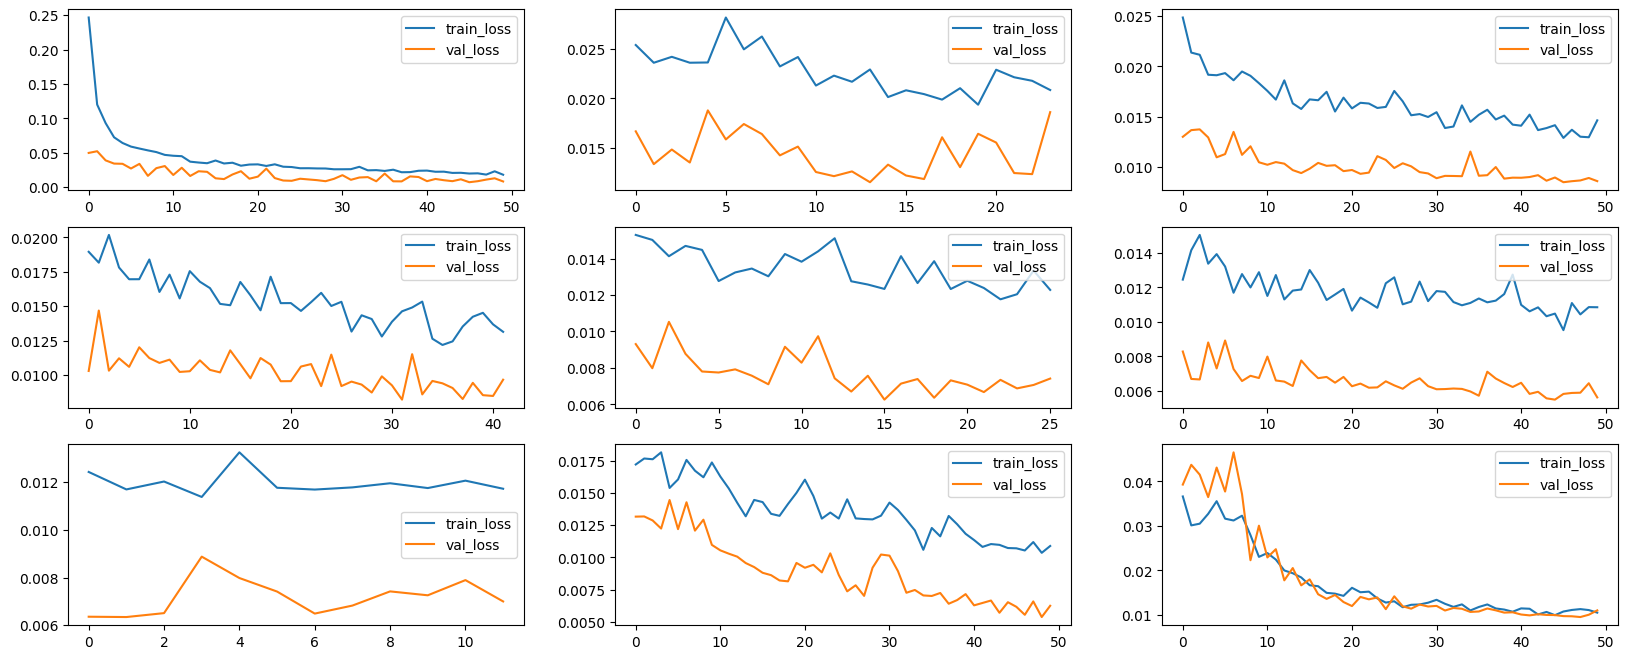

In [37]:
fig, ax = plt.subplots(3, 3, figsize=(20, 8))
i=0
for window in range(9):
    # visualizing losses and accuracy
    train_loss = history[window].history['loss']
    val_loss   = history[window].history['val_loss']
    # plt.title(f'window{window}')
    ax[i//3, i%3].plot(train_loss, label='train_loss')
    ax[i//3, i%3].plot(val_loss, label='val_loss')
    ax[i//3, i%3].legend()
    i+=1
plt.show()


In [38]:
def compute_rmse(predict_value, actual_value):
    absolute_error = np.abs(predict_value - actual_value)
    rmse = np.sqrt(np.mean(absolute_error**2))
    return rmse

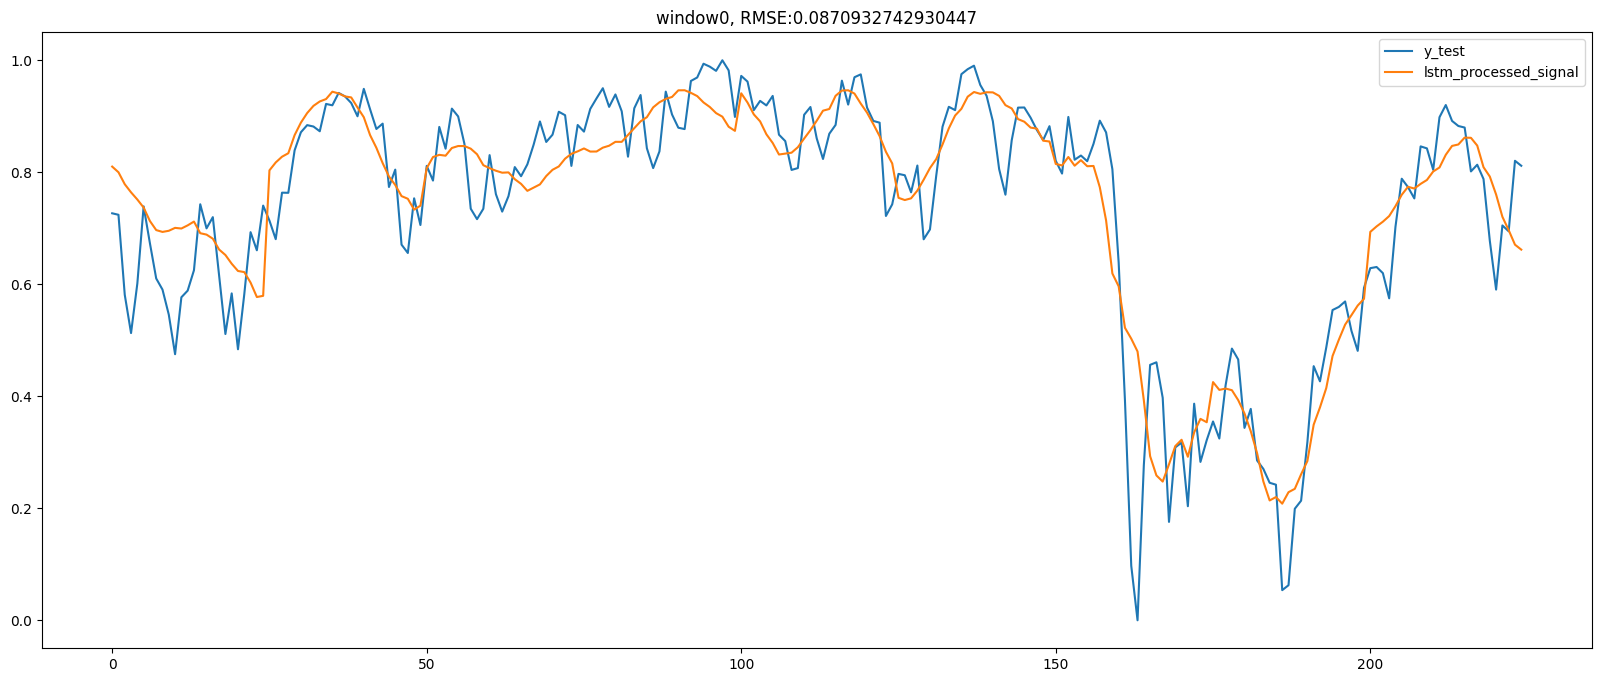

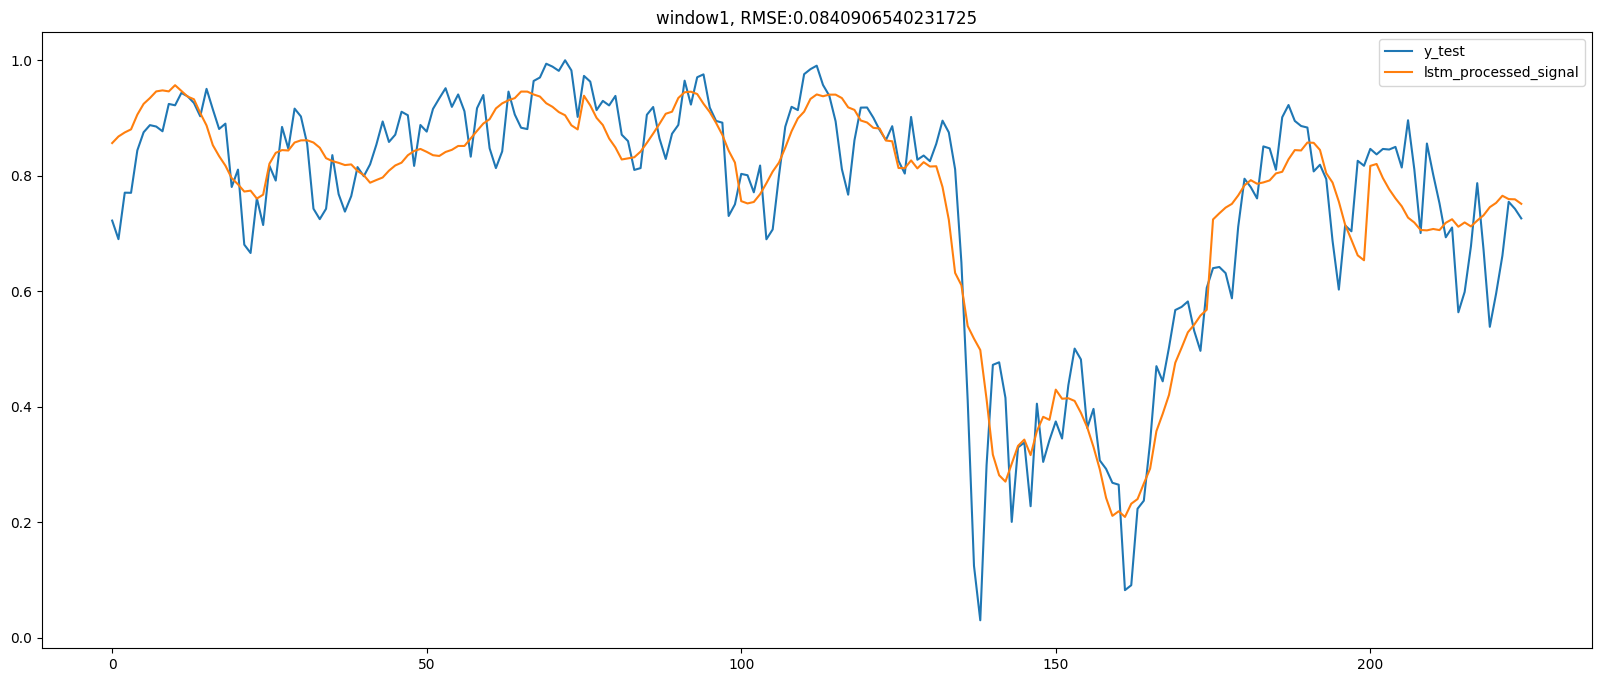

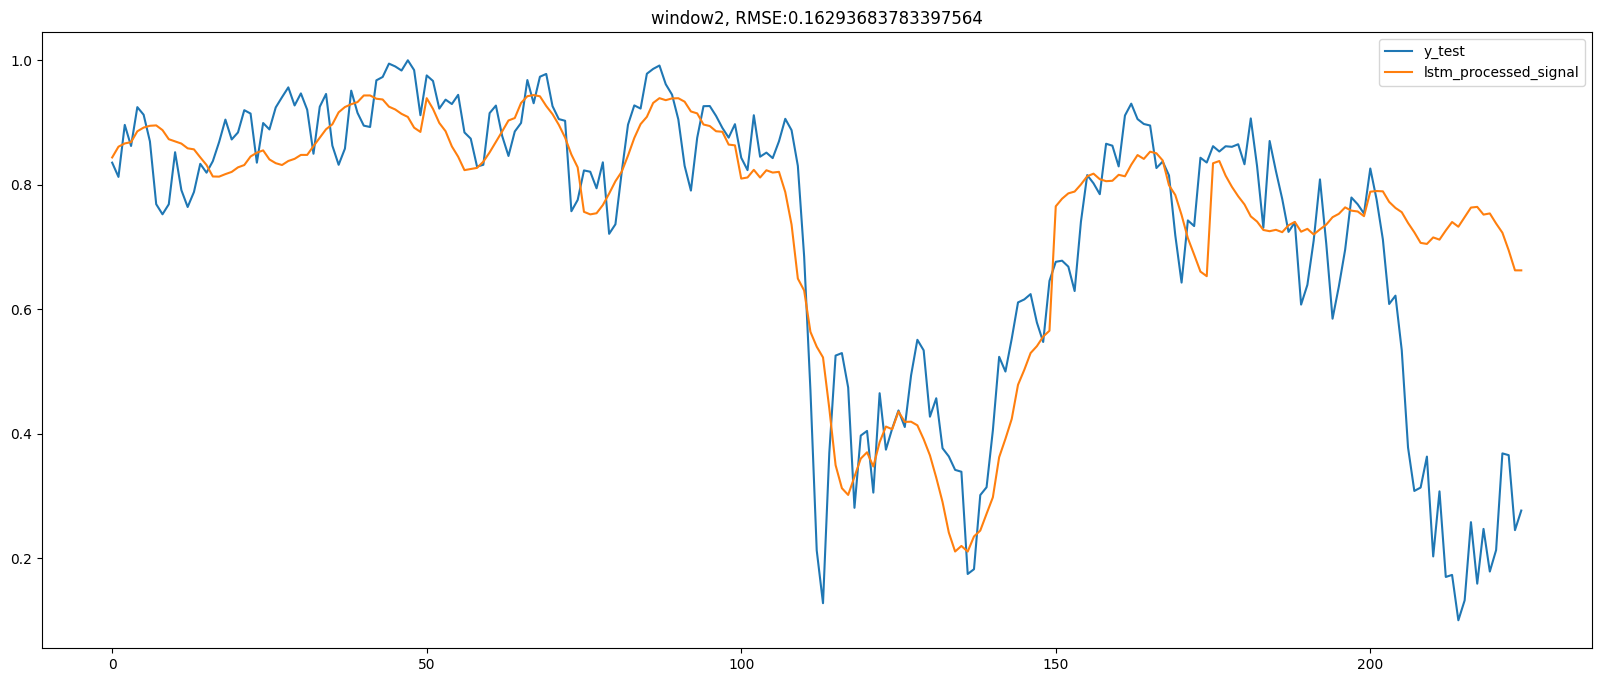

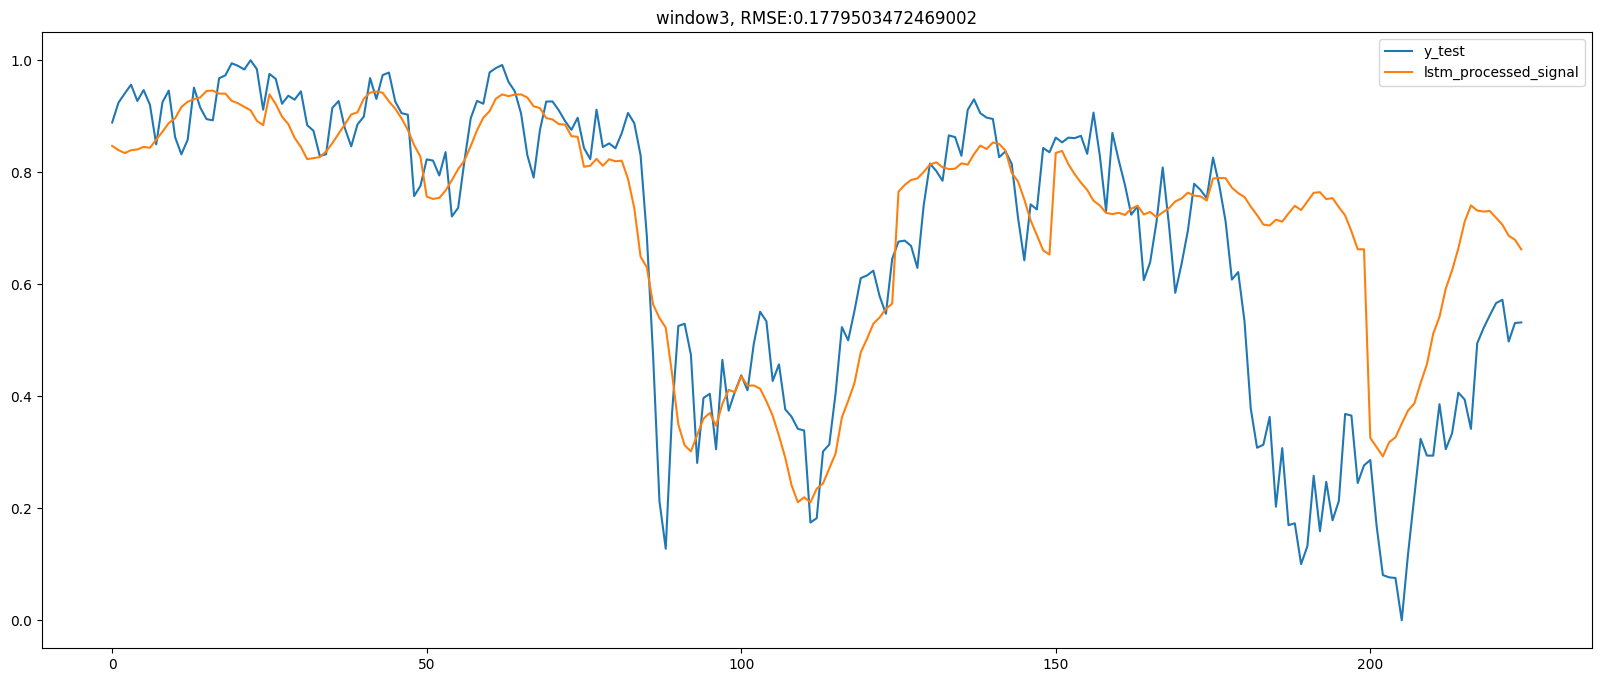

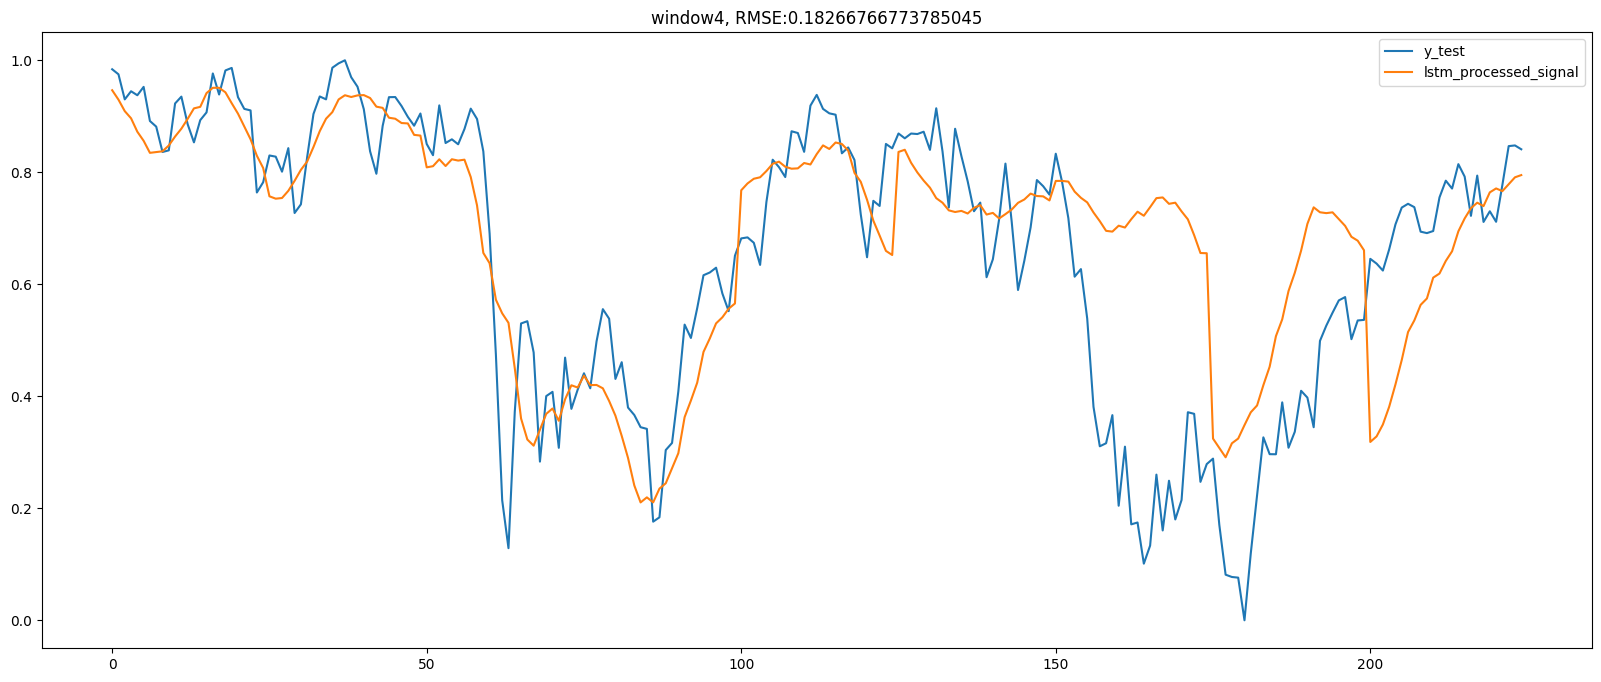

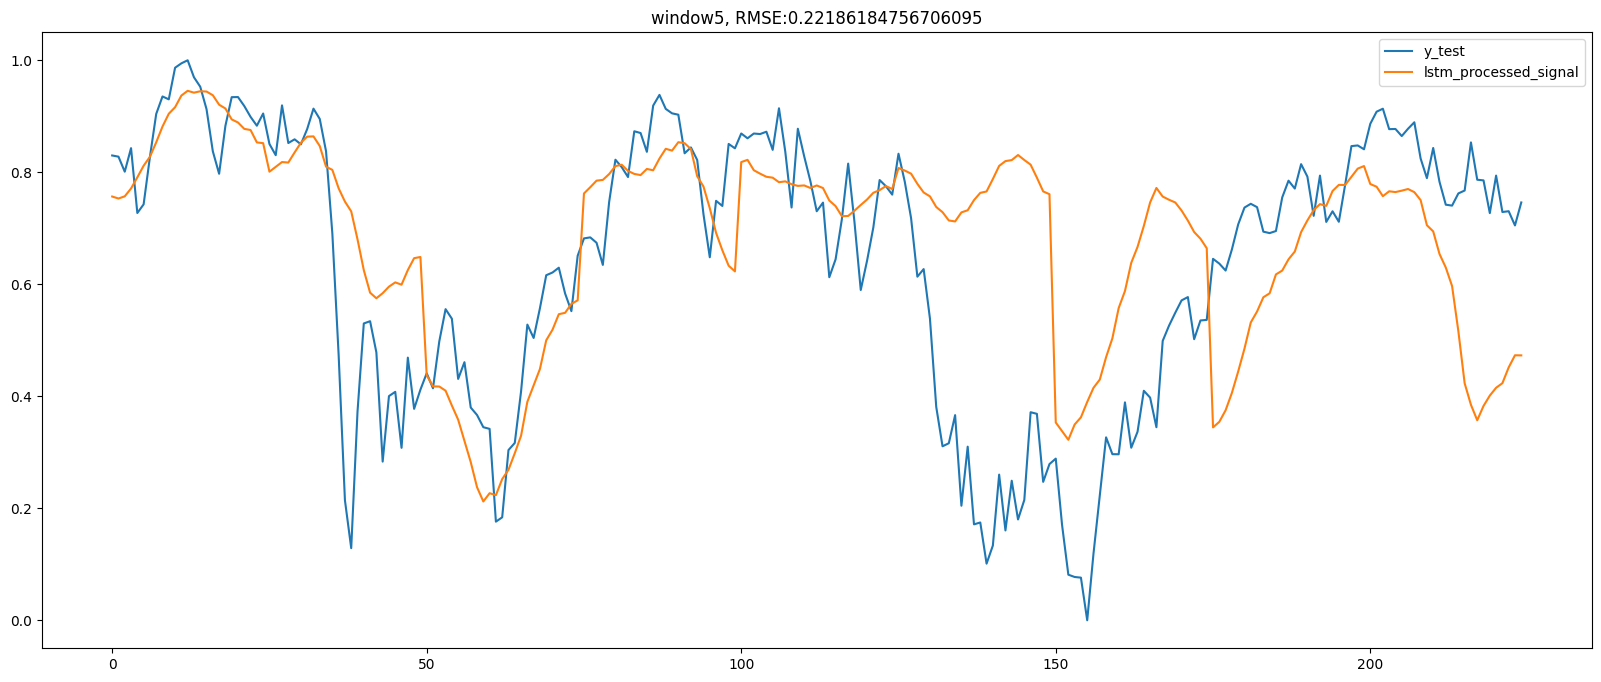

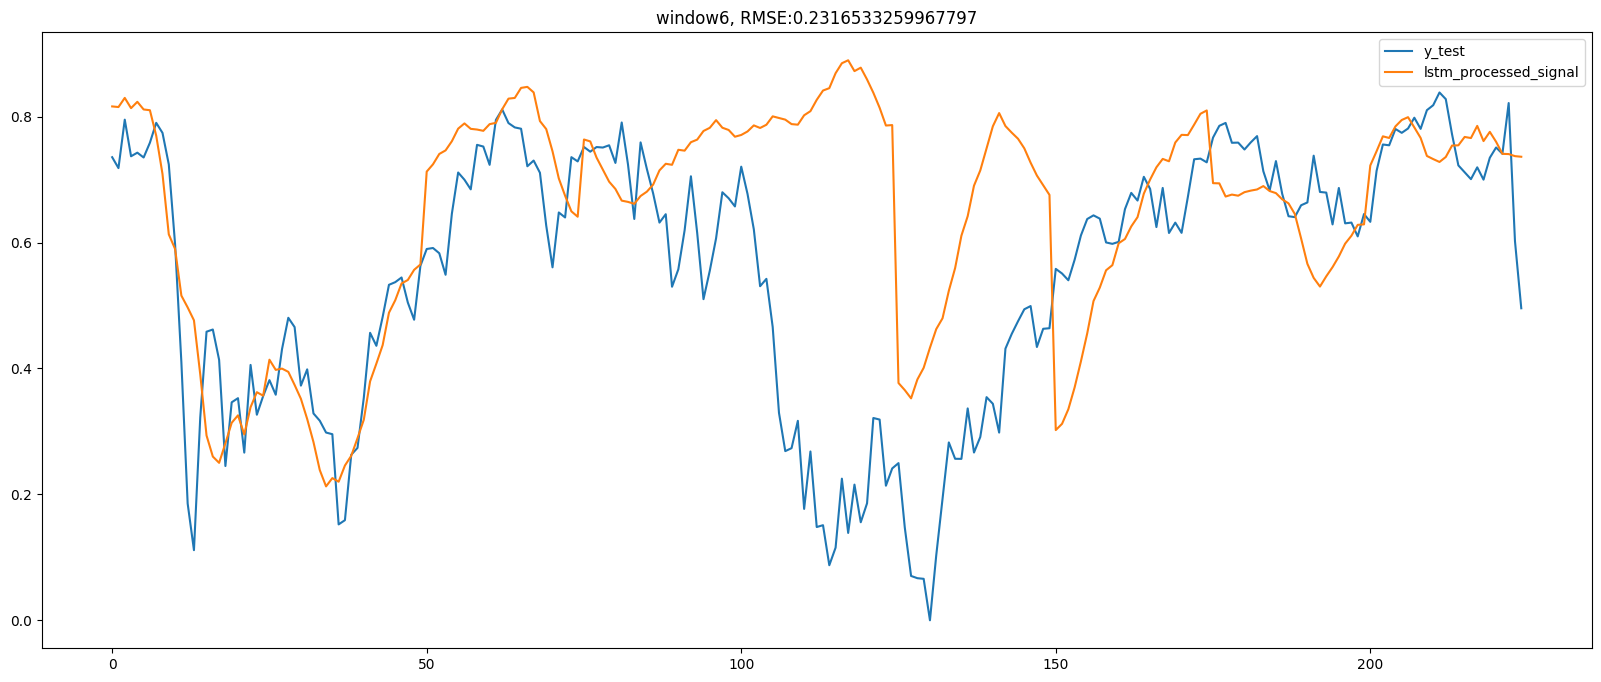

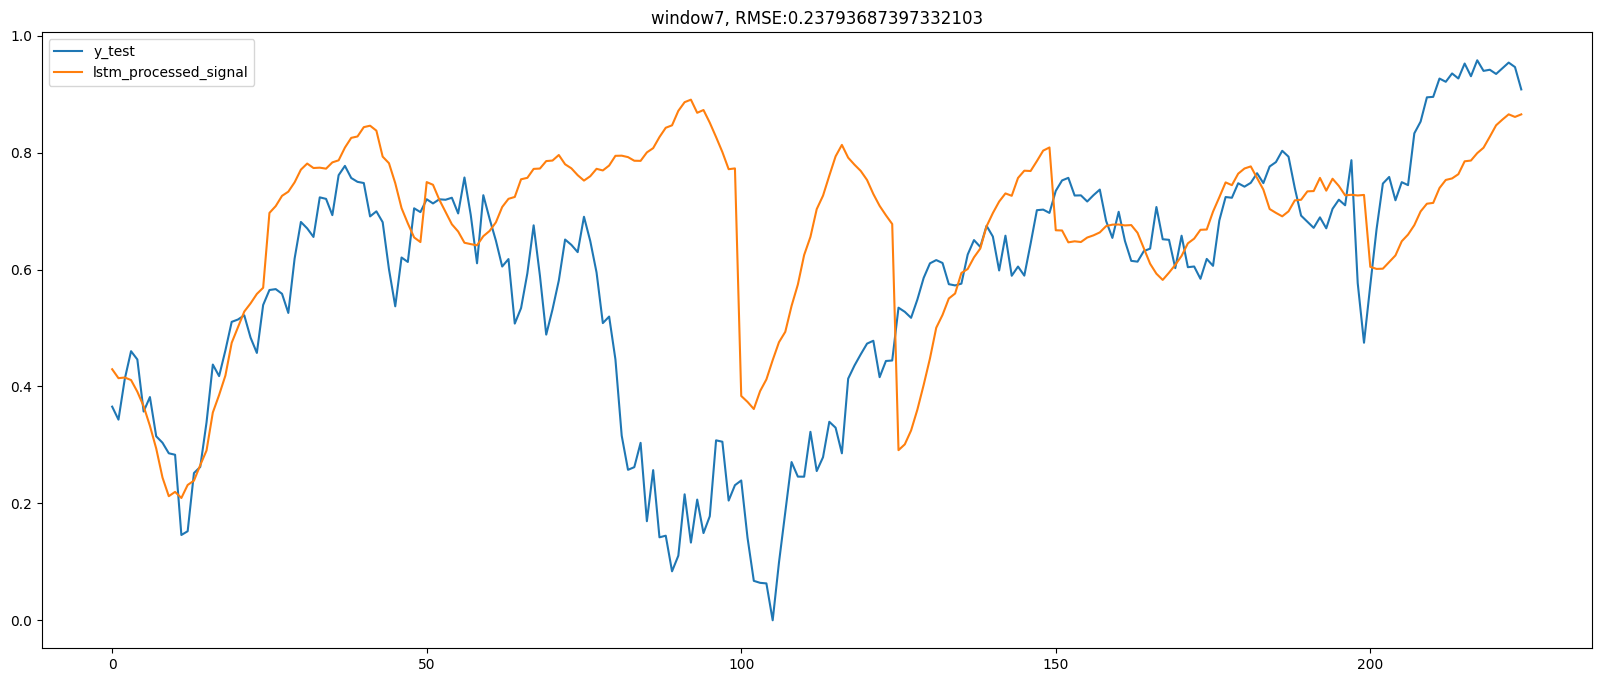

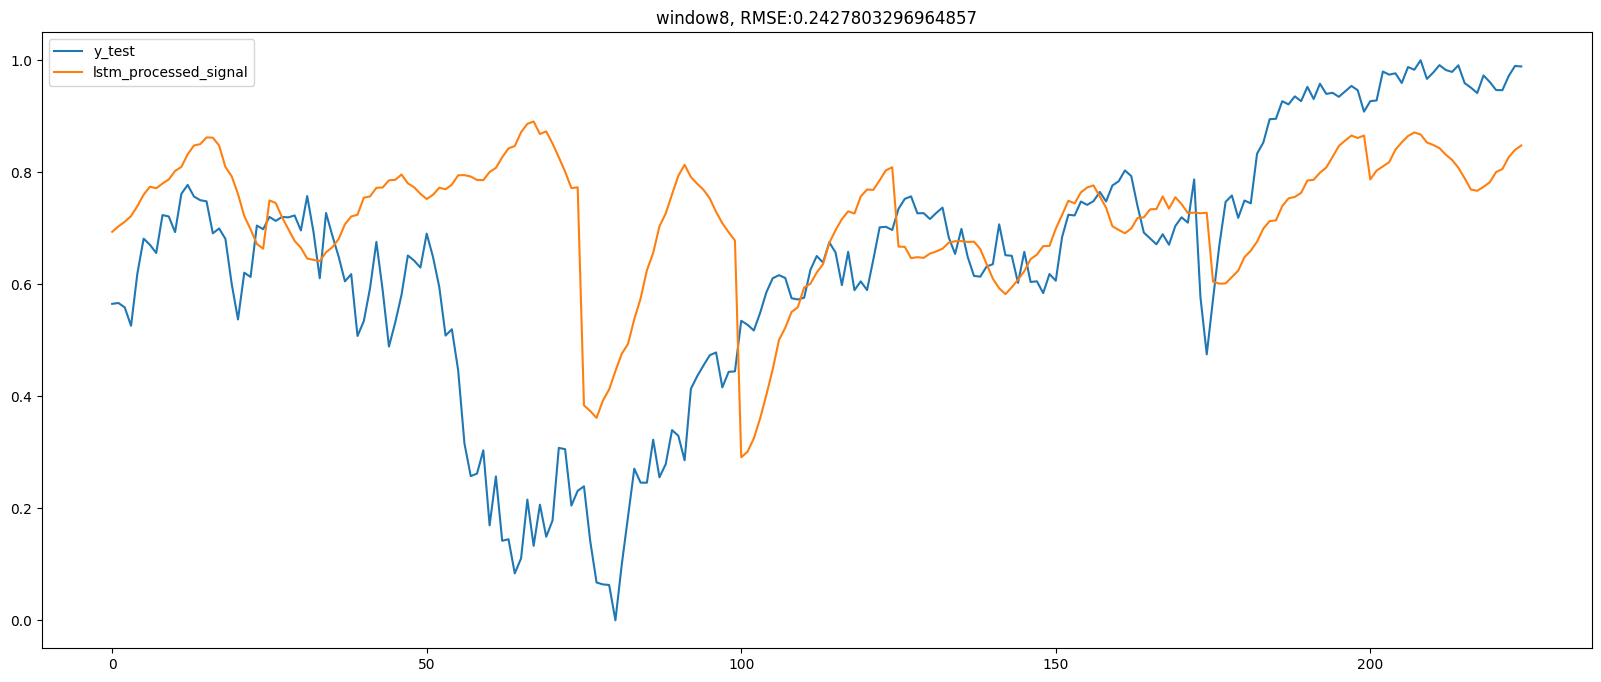

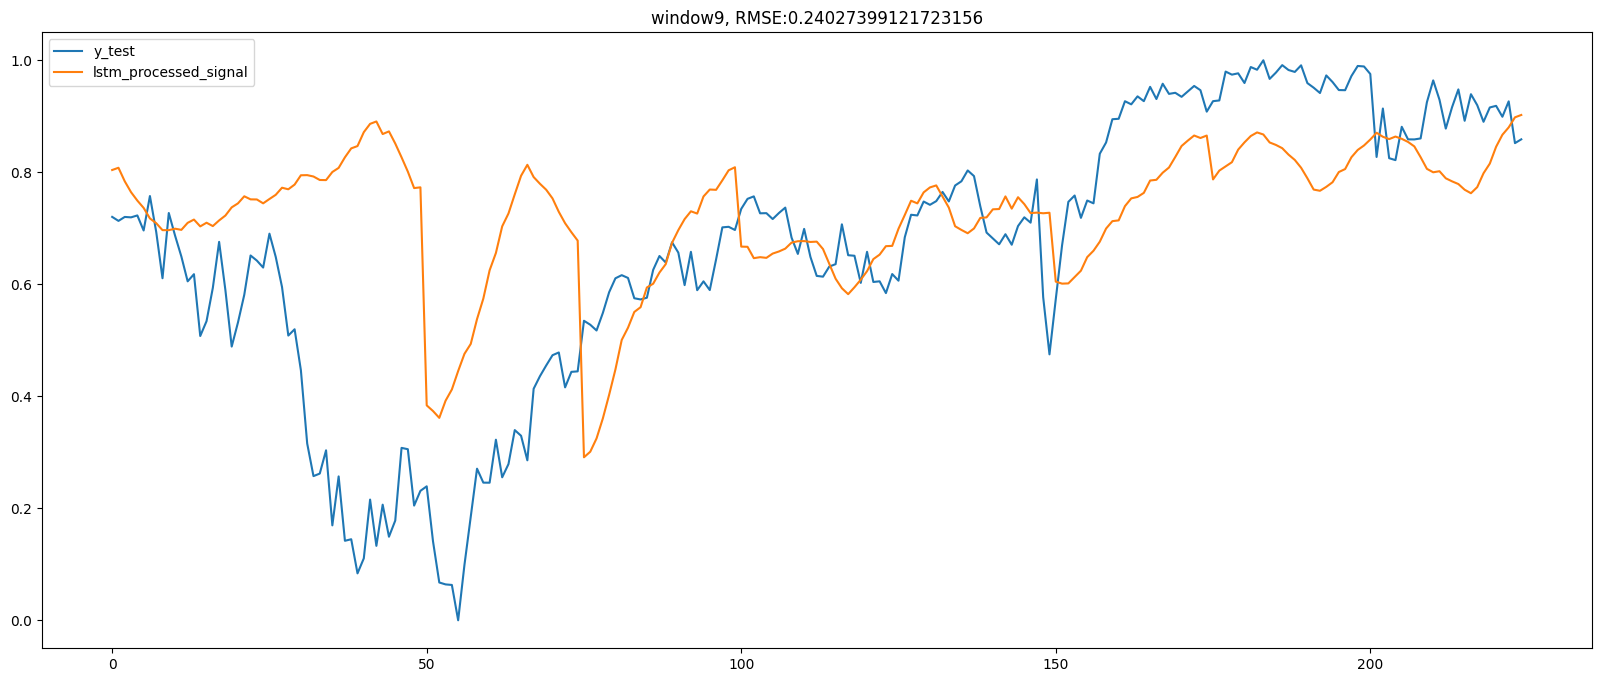

average_rmse=0.18692451495858226


In [39]:
rmse_list = list()
for window in range(test_data.shape[0]):
    RMSE = compute_rmse(lstm_processed_signal[window].flatten(), y_test[window].flatten())
    rmse_list.append(RMSE)
    plt.figure(figsize=(20, 8))
    plt.title(f'window{window}, RMSE:{RMSE}')
    plt.plot(y_test[window].flatten(), label='y_test')
    plt.plot(lstm_processed_signal[window].flatten(), label='lstm_processed_signal')
    plt.legend()
    plt.show()
average_rmse = sum(rmse_list) / len(rmse_list)
print(f'average_rmse={average_rmse}')